In [1]:
# import subprocess

# packages = ['geemap', 'geopandas',
#             'shapely', 'requests', 
#             'osgeo', 'rasterio', 'numpy',
#             'sklearn', 'fiona', 'pyproj',
#             'matplotlib', 'pandas',
#             'seaborn','geocube', 'os']

# for package in packages:
#     try:
#         __import__(package)
#     except ImportError:
#         subprocess.check_call(['pip', 'install', package])

import neccessary libaries

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn
import json
import rasterio as rio
import shapely
import fiona
import warnings

warnings.filterwarnings('ignore')

In [3]:
# load the boundary shapefile for Area of Intrest (AOI)
study_area = gpd.read_file('data/tocantins.shp')
study_area.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry
0,33,BRA,Brazil,27,TO,Estado,State,None,None,"POLYGON ((-48.35310 -5.17391, -48.32085 -5.201..."


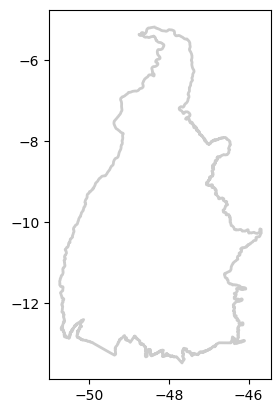

In [4]:
study_area.plot( linewidth=2, color='white', edgecolor='0.8');

The independent variables that will be use in building this model are in raster format, they will be extracted from google earth engine and downloaded uisng geemap and ee API.

In [5]:
# import google eath enigne libary for python
import io
import geemap
import ee

In [6]:
# Autheticate the Google earth engine ee login
key_file = './keys/data-enginerring-zoomcamp-b8719aa4a43e.json'
email = 'farm-watch-project@data-enginerring-zoomcamp.iam.gserviceaccount.com'
try:
    credentials = ee.ServiceAccountCredentials(email=email, key_file=key_file)
    ee.Initialize(credentials)
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

Define ee boundary

In [7]:
# convert the boundary shapefile to ESPG 4326
boundary = study_area

# define a helper function to put the geodataframe in the right format for constructing an ee object
def shp_to_ee_fmt(geodf):
    data = json.loads(geodf.to_json())
    return data['features'][0]['geometry']['coordinates']

# create the ee object
feature_cls = ee.Geometry.MultiPolygon(shp_to_ee_fmt(boundary))

Generate Slope and DEM

In [8]:
#load SRTM data from google earth engine
srtm = ee.Image('CGIAR/SRTM90_V4')

# Generate individual raster data
elevation = srtm.select('elevation')
slope = ee.Terrain.slope(elevation)

Generate LULC

In [9]:
# load ESA 2020 World wide 10m land cover  data form google earth
collection = (
    ee.ImageCollection('ESA/WorldCover/v200')
    .filterBounds(feature_cls)
)

landcover = collection.first()

# collection.aggregate_array('system:index').getInfo()

Generate NDVI, NDMI and BSI

In [10]:
# select Landsat 8 collection for the spectal indices
l8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_TOA") \
    .filterBounds(feature_cls) \
    .filterDate('2021-01-01', '2022-12-31') \
    .sort('CLOUD_COVER') \
    .median()


# Calculate NDVI
ndvi = l8.normalizedDifference(['B5', 'B4'])

# Calculate NDMI
ndmi = l8.normalizedDifference(['B5', 'B6'])

# Calculate BSI
bsi = l8.expression(
    '((SWIR2 + RED) - (SWIR1 + NIR)) / ((SWIR2 + RED) + (SWIR1 + NIR))',
    {
        'SWIR1': l8.select('B6'),
        'SWIR2': l8.select('B6'),
        'NIR': l8.select('B5'),
        'RED': l8.select('B4')
    }
)

Generate LST and SMI

In [11]:
# # Function to calculate LST
# def calculate_LST(image):
#     # Convert TOA radiance to Brightness Temperature (BT)
#     BT = image.expression('1321.0789 / log(774.8853 / radiance + 1) - 273.15',
#                           {'radiance': image.select('TOA')}).rename('Brightness_Temp')
    
#     # Calculate NDVI
#     ndvi = image.normalizedDifference(['B5', 'B4']).rename('ndvi')
    
#     # Find the min and max of NDVI
#     min_ndvi = ee.Number(ndvi.reduceRegion(reducer=ee.Reducer.min(), geometry=region.geometry(),
#                                            scale=30, maxPixels=1e9).values().get(0))
#     max_ndvi = ee.Number(ndvi.reduceRegion(reducer=ee.Reducer.max(), geometry=region.geometry(),
#                                            scale=30, maxPixels=1e9).values().get(0))
    
#     # Calculate Proportion vegetation
#     pv = ndvi.subtract(min_ndvi).divide(max_ndvi.subtract(min_ndvi)).pow(ee.Number(2)).rename('FV')
    
#     # Calculate Emissivity
#     a = ee.Number(0.004)
#     b = ee.Number(0.986)
#     EM = pv.multiply(a).add(b).rename('EMM')
    
#     # Calculate Land Surface Temperature (LST)
#     LST = BT.expression('BT / (1 + (10.8 * BT / 14388) * log(Ep))',
#                         {'BT': BT.select('Brightness_Temp'), 'Ep': EM.select('EMM')}).rename('LST')
    
#     return LST

# # Function to calculate Soil Moisture Index (SMI)
# def calculate_SMI(LST, lst_min, lst_max):
#     # Calculate Soil Moisture Index (SMI)
#     SMI = LST.subtract(lst_min).divide(lst_max.subtract(lst_min)).rename('SMI')
#     return SMI

# # Define region of interest
# region = ee.Geometry.Point(-122.08, 37.38)

# # Example of getting the TOA image
# TOA_image = ee.ImageCollection("LANDSAT/LC08/C02/T1_TOA") \
#     .filterBounds(region) \
#     .filterDate('2021-01-01', '2022-12-31') \
#     .sort('CLOUD_COVER') \
#     .median()

# # Calculate LST
# LST_image = calculate_LST(TOA_image)

# # Print LST image
# print("LST Image:", LST_image)

# # Define minimum and maximum values for LST
# lst_min = 273  # Example value, you may replace it with appropriate value
# lst_max = 320  # Example value, you may replace it with appropriate value

# # Calculate SMI
# SMI_image = calculate_SMI(LST_image, lst_min, lst_max)

# # Print SMI image
# print("SMI Image:", SMI_image)


Generate Temperature and Rainfall data

In [12]:
# Define date range
start_date = '2012-01-01'
end_date = '2022-12-31'

# Load CHIRP precipitation data
rainfall = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
    .filterBounds(feature_cls) \
    .filterDate(start_date, end_date) \
    .select('precipitation') \
    .sum()

# Load average temperature data
temp = ee.ImageCollection('NOAA/CFSV2/FOR6H') \
    .filterBounds(feature_cls) \
    .filterDate(start_date, end_date) \
    .select('Temperature_height_above_ground') \
    .mean()

soil Type

Get Global SOC datasets

In [13]:
# Global SOC soc dataset
soc= ee.Image("OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02")\
        .select('b30')

soc = soc.multiply(0.005)

clip all images to features

In [14]:
# clip all the images load to the study area
elevation_clip  = elevation.clip(feature_cls)
slope_clip = slope.clip(feature_cls)
landcover_clip = landcover.clip(feature_cls)
rainfall_clip = rainfall.clip(feature_cls)
temp_clip = temp.clip(feature_cls)
ndvi_clip = ndvi.clip(feature_cls)
bsi_clip = bsi.clip(feature_cls)
soc_clip = soc.clip(feature_cls)

set Visualization Parameters

In [15]:
# visualization parameters
elevation_viz = {
    'min': 0,
    'max': 4000,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']
}

slope_viz = {
    'min': 0,
    'max': 60,
    'palette': ['brown', 'yellow', 'green']
}

landcover_viz = {
  'min': 0,
  'max': 100,
  'palette': [
      'FC6D26', 'FCAF17', 'E8EB45', '34B334', '4C7EAF',
      'B05AFF', 'A56F37', '914D25', 'BFC0C3', 'FFFFFF',
  ]
}

rainfall_viz = {
    'min': 0,
    'max': 300,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']
}


temp_viz = {
    'min': 0,
    'max': 310.0,
    'palette': ['blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

ndvi_viz = {
    'min': -1,
    'max': 1,
    'palette': ['red', 'yellow', 'green']
}


bsi_viz = {
    'min': -1,
    'max': 1,
    'palette': ['red', 'yellow', 'green']
}


soc_viz = {
  'min': 0.0,
  'max': 120.0,
  'palette': [
    "ffffa0","f7fcb9","d9f0a3","addd8e","78c679","41ab5d",
    "238443","005b29","004b29","012b13","00120b",
  ]
}

Add Data to Map layer to visualize all data

In [16]:
#instatiate Map()
Map = geemap.Map()
# Add all image layer to a basemap
Map.addLayer(elevation_clip, elevation_viz, 'Elevation')
Map.addLayer(slope_clip, slope_viz, 'Slope')
Map.addLayer(landcover_clip, landcover_viz, 'Landcover')
Map.addLayer(rainfall_clip, rainfall_viz, 'Rainfall')
Map.addLayer(temp_clip, temp_viz, 'Temperature')
Map.addLayer(ndvi_clip, ndvi_viz, 'NDVI')
Map.addLayer(bsi_clip, bsi_viz, 'BSI')
Map.addLayer(soc_clip, soc_viz,'soc organic carbon content in x 5 g / kg')

# set map center object
Map.centerObject(elevation_clip, 5)

# call the geemap Map object
Map

Map(center=[-10.14095118527972, -48.32883664541774], controls=(WidgetControl(options=['position', 'transparent…

Save imageries locally so that it can be used to create maps

In [23]:
from utils.export_ee_image import export_ee_image_list

raster_list = [
    slope_clip, landcover_clip,
    rainfall_clip, temp_clip,
    ndvi_clip, bsi_clip, soc_clip,
]

output_list = [
    "slope", "landcover",
    "rainfall", "temp",
    "ndvi", "bsi", "soc",
]

# checking if the directory 
if not os.path.exists("output_images"):      
    # if the directory is not present, then create it. 
    os.makedirs("output_images") 
    
out_folder='output_images'
scale = 1000
region=feature_cls

export_ee_image_list(raster_list,output_list,
                     out_folder,scale,region)

Exporting slope...
output_images\slope.tif already exists.
Exporting landcover...
output_images\landcover.tif already exists.
Exporting rainfall...
output_images\rainfall.tif already exists.
Exporting temp...
Generating URL ...
An error occurred while downloading.
A mapped function's arguments cannot be used in client-side operations
temp downloaded successfully to output_images\temp.tif.
Exporting ndvi...
Generating URL ...
An error occurred while downloading.
A mapped function's arguments cannot be used in client-side operations
ndvi downloaded successfully to output_images\ndvi.tif.
Exporting bsi...
Generating URL ...
An error occurred while downloading.
A mapped function's arguments cannot be used in client-side operations
bsi downloaded successfully to output_images\bsi.tif.
Exporting soc...
output_images\soc.tif already exists.


Geneare random smapling points within the aoi

In [19]:
import random
random.seed(42)
from utils.generate_random_point import generate_random_points

boundary = study_area
num_points = 5000
crs = 4326
random_pnt = generate_random_points(boundary, num_points, crs)
len(random_pnt)

5000

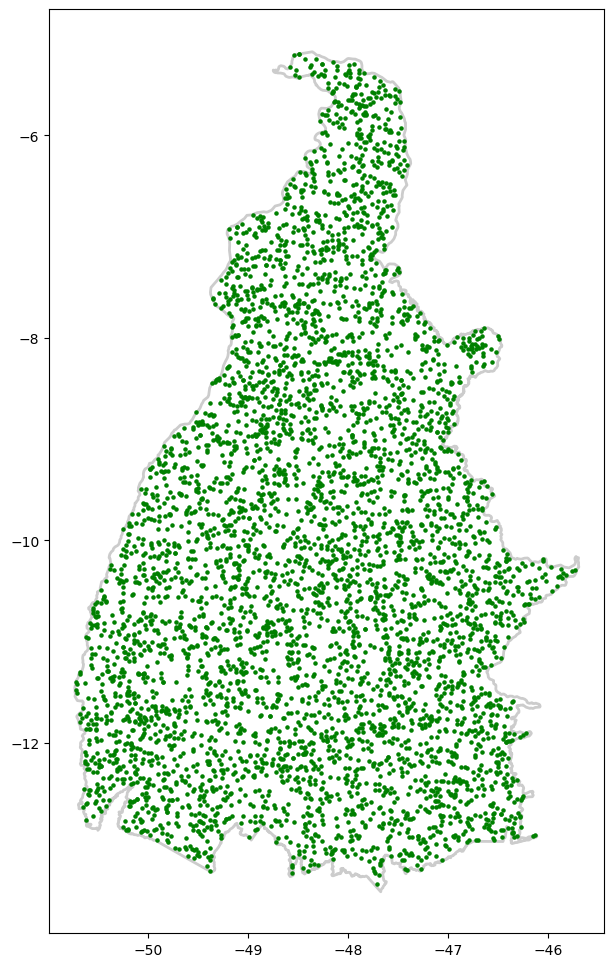

In [20]:
# plot the random points to see the distribution
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(1, 1, 1)
ax = boundary.plot(ax=ax, linewidth=2, color='white', edgecolor='0.8')
random_pnt.plot(ax=ax, markersize=5, color='green');

#### Extract the raster value to the random points to create a sampling_points

In [28]:
# use raterio to load all the data
def open_image(image_path:str):
    image =  rio.open(image_path)
     

landcover = open_image(os.path.join(out_folder,'landcover.tif')) 
landcover.index(x,y)

# landcover
# rainfall
# temp
# ndvi
# bsi
# soc

AttributeError: 'NoneType' object has no attribute 'index'

In [ ]:
from utils.extract_raster_values import get_value_to_point

point_data = random_pnt
raster_list = [
    slope_clip, landcover_clip,
    rainfall_clip, temp_clip,
    ndvi_clip, bsi_clip, soc_clip,
]
sampling_pnts = get_value_to_point(point_data, raster_list) 
sampling_pnts.head()

### Exploratory Data Analysis
- Now lets explore our dataset, we will check for missing value, plot our data and also check the correlation between the dataset
- Examine the relattion among the various varaible that will be sued to build our model
- perform OLS and correlelation analysis to understand the data better

In [ ]:
# read the dataset to view the addeded columns
sampling_points.head()

In [ ]:
#check that there is no no data values in the dataset
print(sampling_points.head().isnull().sum())

In [ ]:
#describe the dataset
sampling_points.describe()

In [ ]:
sampling_points_2 = sampling_points[sampling_points.SOC_gkg>0]
sampling_points_2.describe()

In [ ]:
# show the correlation matric for the dataset
corrMatrix = sampling_points.corr()
fig, ax = plt.subplots(figsize=(6,5))         # Sample figsize in inches
#sns.heatmap(df.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)
sns.heatmap(corrMatrix, annot=True, linewidths=.5, ax=ax)

###  MACHINE LEARNING MODEL

* import the Ml libaries
* load the data
* split the data into dependent and independent variable
* splitt the dataset into training and test test
* Build our model uisng Random Forest Machine Learning Algorithm
* Check the accureacy of our model uisng differernt accracy metrics
* Plot the Predicted data
* Use the prediction  Probabaility output to create a raster map that shows probability of floodding across the study area

In [ ]:
# import require libaries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [ ]:
#load the dataset 
sampling_points.head()

In [ ]:
sampling_points.to_csv('extracted.csv',index=False)

seperating the data into X,y

In [ ]:
# Define the dependent variable that needs to be predicted (labels)
y = sampling_points["SOC_gkg"].values
# Define the independent variables. Let's also drop gemotry and label
x = sampling_points.drop(labels = ["SOC_gkg", "geometry"], axis=1) 
features_list = list(x.columns)  #List features so we can rank their importance later 

Split Data into training and test sets

In [ ]:
import random
random.seed(42)
#Split data into train (60 %), validate (20 %) and test (20%) to verify accuracy after fitting the model.
# training data is used to train the model
# validation data is used for hyperparameter tuning
# testing data is used to test the model

X_train_val, X_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2,shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25,shuffle=True, random_state=42)

Random Forest Regressor Model

In [ ]:
# instantiate the Random Forest Model
model = RandomForestRegressor(n_estimators =1000, random_state = 42)

# Train the model on training data
model.fit(X_train, y_train)

# make prediction for the test dataset.
prediction = model.predict(X_test)

# The prediction SOC value
prediction[:10]

In [ ]:
y_test[:10]

In [ ]:
model.score(X_test,y_test)

#### Metric Evaluation

R2

In [ ]:
r2_score(X_test,y_test)

RMSE

MAE

In [ ]:
mae = mean_absolute_error(y_test,prediction)
mae

Features Importance

In [ ]:
# Estimate the feature importance
feature_imp = pd.Series(model.feature_importances_, index=features_list).sort_values(ascending=False)
print(feature_imp)

# Plot the feature importance 
feature_imp.plot.bar();

Classification Accuracy

In [ ]:
# Calculate the accuracy score
accuracy = r2_score(y_test, prediction)

# Print the accuracy as a percentage
print("Accuracy: {:.2%}".format(accuracy))

Using the different Model Developed to PRedict the SOC Value for 20,000 points

Generate 20000 new random points predictions points within the study


In [ ]:
import random
random.seed(42)
from utils.generate_random_point import generate_random_points

boundary = study_area
num_points = 5000
crs = 4326
random_pnt = generate_random_points(boundary, num_points, crs)
len(random_pnt.head)

In [ ]:
# plot the random points to see the distribution
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(1, 1, 1)
ax = boundary.plot(ax=ax, linewidth=2, color='white', edgecolor='0.8')
random_pnt.plot(ax=ax, markersize=5, color='green');

Extract all the values from the independent raster data to the predictive random points

In [ ]:
from utils.extract_raster_values import get_value_to_point

point_data = random_pnt
raster_list = [
    slope_clip, landcover_clip,
    rainfall_clip, temp_clip,
    ndvi_clip, bsi_clip, soc_clip,
]
sampling_pnts = get_value_to_point(point_data, raster_list) 
sampling_pnts.head()

 Dropall the columns except the predictive features

In [ ]:
predicitve_data = predictive_points.drop(labels = ["geometry"], axis=1)
predicitve_data.head()